In [ ]:
import sys
sys.path.insert(0,'python')
from get_modis import *

In [ ]:
fhead = 'data/50SMG20164100'
import glob
import datetime
import calendar
fh = fhead.split('20')[0]
files = glob.glob('%s*B01.jp2'%fh)
dates = []
ds = []
de = []
sys = []
eys = []
for i in files:
    date = datetime.datetime.strptime((i.split('%s'%fh)[1]).split('0B01.jp2')[0], "%Y%m%d")
    dates.append(date)
    doy = date.timetuple().tm_yday
    if doy - 8 <0:
        sys.append(date.year-1)
        days = (datetime.date(date.year,1,1)-datetime.date(date.year-1,1,1)).days
        ds.append(doy-8+days)
    else:
        sys.append(date.year)
        ds.append(doy-8)

    if doy + 8 > 366:
        eys.append(date.year+1)
        days = (datetime.date(date.year+1,1,1)-datetime.date(date.year,1,1)).days
        ds.append(doy+8-days)
    else:
        eys.append(date.year)
        de.append(doy+8)

In [25]:
days = (datetime.date(2016+1,1,1)-datetime.date(2016,1,1)).days

In [ ]:
fhead = 'data/50SMG20164100'
fh = fhead.split('20')[0]
files = glob.glob('%s*B01.jp2'%fh)
dates = []
ds = []
de = []
sys = []
eys = []
for j,i in enumerate(files):
    
    date = datetime.datetime.strptime((i.split('%s'%fh)[1]).split('0B01.jp2')[0], "%Y%m%d")
    if j > 0:
        if (date - dates[-1]).days > 30:
            
            m = ((i.split('%s'%fh)[1]).split('0B01.jp2')[0])[4]
            d = ((i.split('%s'%fh)[1]).split('0B01.jp2')[0])[5:]
            date = datetime.datetime(date.year,int(m),int(d))
            dates.append(date)
        
        elif (date - dates[-1]).days < 0:
            for k in xrange(j):
                m = (files[k].split('%s'%fh)[1]).split('0B01.jp2')[0][4]
                d = (files[k].split('%s'%fh)[1]).split('0B01.jp2')[0][5:]
                dates[k] = datetime.datetime(date.year,int(m),int(d))
           
            
        else:
            dates.append(date)
    else:
        dates.append(date)
    doy = date.timetuple().tm_yday
    if doy - 8 <= 0:
        
        sys.append(date.year-1)
        days = (datetime.date(date.year,1,1)-datetime.date(date.year-1,1,1)).days
        ds.append(doy-8+days)
        
    else:
        sys.append(date.year)
        ds.append(doy-8)

    if doy + 8 > 366:
        eys.append(date.year+1)
        days = (datetime.date(date.year+1,1,1)-datetime.date(date.year,1,1)).days
        de.append(doy+8-days)
    else:
        eys.append(date.year)
        de.append(doy+8)


for i in range(len(sys)-1):

    if sys[i] == eys[i]:
        get_modisfiles( 'MOTA', 'MCD43A1.005', sys[i], 'h27v05', None, 
                       doy_start=ds[i], doy_end=de[i], out_dir='m_data/' )
        get_modisfiles( 'MOTA', 'MCD43A2.005', sys[i], 'h27v05', None, 
                       doy_start=ds[i], doy_end=de[i], out_dir='m_data/' )
        get_modisfiles( 'MOTA', 'MCD43A3.005', sys[i], 'h27v05', None, 
                       doy_start=ds[i], doy_end=de[i], out_dir='m_data/' )
    else :
        days = (datetime.date(sys[i]+1,1,1)-datetime.date(sys[i],1,1)).days
        
        get_modisfiles( 'MOTA', 'MCD43A1.005',
                       sys[i], 'h27v05', None, doy_start=ds[i],
                       doy_end=days, out_dir='m_data/' )
        get_modisfiles( 'MOTA', 'MCD43A1.005',
                       eys[i], 'h27v05', None, doy_start=1,
                       doy_end=de[i], out_dir='m_data/')
        
        get_modisfiles( 'MOTA', 'MCD43A2.005',
                       sys[i], 'h27v05', None, doy_start=ds[i],
                       doy_end=days, out_dir='m_data/' )
        get_modisfiles( 'MOTA', 'MCD43A2.005',
                       eys[i], 'h27v05', None, doy_start=1,
                       doy_end=de[i], out_dir='m_data/')
        
        get_modisfiles( 'MOTA', 'MCD43A3.005',
                       sys[i], 'h27v05', None, doy_start=ds[i],
                       doy_end=days, out_dir='m_data/' )

        get_modisfiles( 'MOTA', 'MCD43A3.005',
                       eys[i], 'h27v05', None, doy_start=1,
                       doy_end=de[i], out_dir='m_data/')

In [58]:
import numpy as np
from osgeo import ogr
from osgeo import osr
import mgrs
from scipy.interpolate import griddata

def get_lon_lat(fhead):
    #fhead = 'data/50SMG20164100'
    # generate a list of the forth and fifth letter
    a = map(chr, range(65, 91))
    a.remove('I')
    a.remove('O')
    
    #get the corner coordinates for each tile
    # the mgrs gives the lower left coordinate

    t = fhead.split('201')[0][-5:]
    bl = t
    ul = t.replace(t[-1], a[a.index(t[-1])+1])
    br = t.replace(t[-2], a[a.index(t[-2])+1])
    ur = t.replace(t[-2], a[a.index(t[-2])+1]).replace(t[-1], a[a.index(t[-1])+1])
    
    m = mgrs.MGRS()
    b_l = list(m.toLatLon(bl))
    u_l = list(m.toLatLon(ul))
    b_r = list(m.toLatLon(br))
    u_r = list(m.toLatLon(ur))
    
    return np.array([u_l, u_r, b_l, b_r])

def transform():
    wgs84 = osr.SpatialReference( ) # Define a SpatialReference object
    wgs84.ImportFromEPSG( 4326 ) # And set it to WGS84 using the EPSG code
    modis_sinu = osr.SpatialReference() # define the SpatialReference object
    # In this case, we get the projection from a Proj4 string
    modis_sinu.ImportFromProj4 ( \
                    "+proj=sinu +R=6371007.181 +nadgrids=@null +wktext")
    tx = osr.CoordinateTransformation( wgs84, modis_sinu )
    
    return tx

def get_mextend():
    tx = transform()
    
    m_lon1, modis_lat, modis_z = tx.TransformPoint (180, 0)
    m_lon0, modis_lat, modis_z = tx.TransformPoint (-180, 0)
    modis_lon, m_lat0, modis_z = tx.TransformPoint (0, 90)
    modis_lon, m_lat1, modis_z = tx.TransformPoint (0, -90)
    
    return (m_lon0, m_lon1, m_lat0, m_lat1)

def get_steps():
    m_lon0, m_lon1, m_lat0,m_lat1 = get_mextend()
    
    lon_step = (m_lon1-m_lon0)/36.
    lat_step = (m_lat0-m_lat1)/18.
    lon_cstep = lon_step/2400.
    lat_cstep = lon_step/2400.
    
    return (lon_step, lat_step, lon_cstep, lat_cstep)


def get_coords(m_lon, m_lat):
    
    #tx = transform()
    
    #m_lon, m_lat, m_z = tx.TransformPoint(lon, lat)
    
    lon_step, lat_step, lon_cstep, lat_cstep = get_steps()
   
    
    m_lon0, m_lon1, m_lat0, m_lat1 = get_mextend()
    
    v = ((m_lat0 - m_lat)/lat_step).astype('int')
    h = ((m_lon - m_lon0)/lon_step).astype('int')
    
    p_x = np.ceil((m_lat0 - m_lat)/lat_cstep) - (v)*2400 
    p_y = np.ceil((m_lon - m_lon0)/lon_cstep) - (h)*2400

    return p_x.astype('int'), p_y.astype('int')

def interp(m_lats, m_lons):
    
    x = [0, 0, 10980, 10980]
    y = [0,10980, 0, 10980]
    corinds = np.array([x,y]).T
    
    grid_x, grid_y = np.mgrid[0:10980, 0:10980]
    Alats = griddata(corinds, m_lats, (grid_x, grid_y), method='linear')
    Alons = griddata(corinds, m_lons, (grid_x, grid_y), method='linear')
    
    return (Alats, Alons)

def get_inds(fhead):
    
    tx = transform()
    cors = get_lon_lat(fhead)
    '''
    #indexes = []
    #for i in cors:
     #   indexes.append(get_coords(cors[1], cors[0]))
    
    cor_lats = cors[:,0]; cor_lons = cors[:,1]
    cds = zip(cor_lons,cor_lats)
    print cds
    
    mc = tx.TransformPoints(cds)
    print mc
    
    m_lats = np.array([i[0] for i in mc])
    m_lons = np.array([i[1] for i in mc])
    
    print m_lats, m_lons
    '''
    cor_coords = []
    #print cors
    for i in cors:
        cor_coords.append(tx.TransformPoint(i[1], i[0]))
    
    m_lats = np.array([i[1] for i in cor_coords])
    m_lons = np.array([i[0] for i in cor_coords])

    m_lats, m_lons = interp(m_lats, m_lons)
    Alats, Alons = get_coords(m_lons, m_lats)
    
    return Alats, Alons

In [57]:
fname = '50SMG20164100'
Alats, Alons = get_inds(fname)

[ 4218972.14923394  4219584.19482309  4118764.08272106  4119356.63374727]


In [59]:
Alats, Alons

(array([[494, 494, 494, ..., 493, 493, 493],
        [494, 494, 494, ..., 493, 493, 493],
        [494, 494, 494, ..., 493, 493, 493],
        ..., 
        [711, 711, 711, ..., 709, 709, 709],
        [711, 711, 711, ..., 709, 709, 709],
        [711, 711, 711, ..., 709, 709, 709]]),
 array([[330, 330, 330, ..., 544, 544, 544],
        [330, 330, 330, ..., 544, 544, 544],
        [330, 330, 330, ..., 544, 544, 544],
        ..., 
        [599, 599, 599, ..., 812, 812, 812],
        [599, 599, 599, ..., 812, 812, 812],
        [599, 599, 599, ..., 812, 812, 813]]))

In [14]:
m_lon1, modis_lat, modis_z = tx.TransformPoint (180, 0)
m_lon0, modis_lat, modis_z = tx.TransformPoint (-180, 0)
modis_lon, m_lat0, modis_z = tx.TransformPoint (0, 90)
modis_lon, m_lat1, modis_z = tx.TransformPoint (0, -90)
m_lon0, m_lon1, m_lat0,m_lat1

(-20015109.35579742,
 20015109.35579742,
 10007554.677898709,
 -10007554.677898709)

In [15]:
lon_step = (m_lon1-m_lon0)/36.
lat_step = (m_lat0-m_lat1)/18.
lon_cstep = lon_step/2400.
lat_cstep = lon_step/2400.

In [16]:
lon_step,lat_step,lon_cstep,lat_cstep

(1111950.5197665235, 1111950.5197665233, 463.3127165693848, 463.3127165693848)

In [26]:
m_lon, m_lat, m_z = tx.TransformPoint (115.86192607, 37.94208532)

In [27]:
m_lon, m_lat

(10160169.804644033, 4218972.149259977)

In [36]:
v = int((m_lat0 - m_lat)/lat_step)
h = int((m_lon - m_lon0)/lon_step)

In [37]:
h,v

(27, 5)

In [446]:
p_x = np.ceil((m_lat0 - m_lat)/lat_cstep) - (v)*2400 
p_y = np.ceil((m_lon - m_lon0)/lon_cstep) - (h)*2400

In [447]:
p_x, p_y

(494.0, 330.0)

In [13]:
import numpy as np
from osgeo import ogr
from osgeo import osr
import mgrs
from scipy.interpolate import griddata

wgs84 = osr.SpatialReference( ) # Define a SpatialReference object
wgs84.ImportFromEPSG( 4326 ) # And set it to WGS84 using the EPSG code
modis_sinu = osr.SpatialReference() # define the SpatialReference object
# In this case, we get the projection from a Proj4 string
modis_sinu.ImportFromProj4 ( \
                "+proj=sinu +R=6371007.181 +nadgrids=@null +wktext")
tx = osr.CoordinateTransformation( wgs84, modis_sinu )

modis_x, modis_y0, modis_z = tx.TransformPoint (180, 0)
modis_x, modis_y1, modis_z = tx.TransformPoint (-180, 0)
modis_x0, modis_y, modis_z = tx.TransformPoint (0, 90)
modis_x1, modis_y, modis_z = tx.TransformPoint (0, -90)

#horizontal tilewidth
htw = (modis_x0 - modis_x1)/36.
#cell size
hcs = htw/2400.
# vertical tilewidth
vtw = (modis_y0 - modis_y1)/18.
#vertical cell size 
vcs = vtw/2400.

def m_pc(cd):
    '''
    Single point transformation
    '''
    lat = cd[1]
    lon = cd[0]
    
    m_lon, m_lat, m_z = tx.TransformPoint (lon, lat)
    h = int((m_lon - modis_x1)/htw) # start from 0 so int would be enough
    v = int((modis_y0 - m_lat)/vtw) 
    
    
    p_x = np.ceil((m_x - modis_x1)/hcs) - (h)*2400 # start from 0 so h not h-1 
    p_y = np.ceil((modis_y0 - m_y)/vcs) - (v)*2400 # but the pixel start from 1 so use ceil value

    return (h,v,p_x,p_y)

def s_pc(fhead):
    #fhead = 'data/50SMG20164100'
    # generate a list of the forth and fifth letter
    a = map(chr, range(65, 91))
    a.remove('I')
    a.remove('O')
    
    #get the corner coordinates for each tile
    # the mgrs gives the lower left coordinate

    t = fhead.split('201')[0][-5:]
    m1 = t
    m2 = t.replace(t[-1], a[a.index(t[-1])+1])
    m3 = t.replace(t[-2], a[a.index(t[-2])+1])
    m4 = t.replace(t[-2], a[a.index(t[-2])+1]).replace(t[-1], a[a.index(t[-1])+1])
    
    m = mgrs.MGRS()
    b_l = list(m.toLatLon(m1))
    u_l = list(m.toLatLon(m2))
    b_r = list(m.toLatLon(m3))
    u_r = list(m.toLatLon(m4))
    
    '''
    m_bl = m_pc(b_l)
    m_ul = m_pc(u_l)
    m_br = m_pc(b_r)
    m_ur = m_pc(u_r)
    '''
    
    return [u_l, u_r, b_l, b_r]

    '''
    c = s_pc('data/50SMG20164100')

    x = [0, 0, 10980, 10980]
    y = [0,10980, 10980, 0]
    ps = np.array([x,y]).reshape(4,2)
    lats= np.array([lat for lat, lon in c])
    lons = np.array([lon for lat, lon in c])

    grid_x, grid_y = np.mgrid[0:10980, 0:10980]
    p_lat = griddata(ps, lats, (grid_x, grid_y), method='cubic')
    p_lon = griddata(ps, lons, (grid_x, grid_y), method='cubic')
    f_lat = p_lat.ravel()
    f_lon = p_lon.ravel()
    cds = zip(f_lat,f_lon)
    mc = tx.TransformPoints(cds)
    '''


In [ ]:
import multiprocessing
from functools import partial
import numpy as np
c = np.array(s_pc('data/50SMG20164100'))
x = [0, 0, 10980, 10980]
y = [0,10980, 0, 10980]
ps = np.array([x,y]).T

lats = c[:,0]
lons = c[:,1]

def trans(ps, (grid_x, grid_y), coor = None):
    print ps
    coord = coor
    return griddata(ps, coord, (grid_x, grid_y), method='linear')

grid_x, grid_y = np.mgrid[0:10980, 0:10980]

par = partial(trans,ps, (grid_x, grid_y))

pool = multiprocessing.Pool(processes=2)
p_coords = pool.map(par,[c[:,0], c[:,1]],1)
pool.close()
pool.join()


#p_lat = griddata(ps, lats, (grid_x, grid_y), method='cubic')
#p_lon = griddata(ps, lons, (grid_x, grid_y), method='cubic')

f_lat = p_coords[0].ravel()
f_lon = p_coords[1].ravel()
cds = zip(f_lon,f_lat)

mc = tx.TransformPoints(cds)

m_x = np.array([i[0] for i in mc])
m_y = np.array([i[1] for i in mc])

h = ((m_x - modis_x1)/htw).astype(int) 
v = ((modis_y0 - m_y)/vtw).astype(int)

p_x = np.ceil((m_x - modis_x1)/hcs) - (h)*2400 # start from 0 so h not h-1 
p_y = np.ceil((modis_y0 - m_y)/vcs) - (v)*2400


In [15]:
import multiprocessing
from functools import partial
import numpy as np
import numpy as np
from osgeo import ogr
from osgeo import osr
import mgrs
from scipy.interpolate import griddata
import cPickle as pkl

def s_pc(fhead):
    #fhead = 'data/50SMG20164100'
    # generate a list of the forth and fifth letter
    a = map(chr, range(65, 91))
    a.remove('I')
    a.remove('O')
    
    #get the corner coordinates for each tile
    # the mgrs gives the lower left coordinate

    t = fhead.split('201')[0][-5:]
    m1 = t
    m2 = t.replace(t[-1], a[a.index(t[-1])+1])
    m3 = t.replace(t[-2], a[a.index(t[-2])+1])
    m4 = t.replace(t[-2], a[a.index(t[-2])+1]).replace(t[-1], a[a.index(t[-1])+1])
    
    m = mgrs.MGRS()
    
    b_l = list(m.toLatLon(m1))
    u_l = list(m.toLatLon(m2))
    b_r = list(m.toLatLon(m3))
    u_r = list(m.toLatLon(m4))
    
    return [u_l, u_r, b_l, b_r]



def trans(ps, (grid_x, grid_y), coor = None):
    print ps
    coord = coor
    return griddata(ps, coord, (grid_x, grid_y), method='linear')

def coordarray(fhead):
 
    c = np.array(s_pc(fhead))
    x = [0, 0, 10980, 10980]
    y = [0,10980, 0, 10980]
    ps = np.array([x,y]).T

    lats = c[:,0]
    lons = c[:,1]
    grid_x, grid_y = np.mgrid[0:10980, 0:10980]
    
    p_lat = griddata(ps, lats, (grid_x, grid_y), method='linear')
    p_lon = griddata(ps, lons, (grid_x, grid_y), method='linear')
    #par = partial(trans,ps, (grid_x, grid_y))

    #pool = multiprocessing.Pool(processes=2)
    #p_coords = pool.map(par,[c[:,0], c[:,1]],1)
    #pool.close()
    #pool.join()
    
    f_lat = p_lat.ravel()
    f_lon = p_lon.ravel()
    
    cds = zip(f_lon,f_lat)
    mc = tx.TransformPoints(cds)

    m_x = np.array([i[0] for i in mc])
    m_y = np.array([i[1] for i in mc])
    
    return (m_x, m_y, modis_x1, modis_y0)

def cal_coords(fhead):
    
    tx, htw, hcs, vtw, vcs, modis_x1, modis_y0 = geo_transform()
    
    m_x, m_y = coordarray(fhead)
    
    h = ((m_x - modis_x1)/htw).astype(int) 
    v = ((modis_y0 - m_y)/vtw).astype(int)

    p_x = np.ceil((m_x - modis_x1)/hcs) - (h)*2400 # start from 0 so h not h-1 
    p_y = np.ceil((modis_y0 - m_y)/vcs) - (v)*2400
    
    return np.array([p_x, p_y])

def geo_transform():
    # specified for the MODIS and Sentinel 2 geo_transform
    
    wgs84 = osr.SpatialReference( ) # Define a SpatialReference object
    wgs84.ImportFromEPSG( 4326 ) # And set it to WGS84 using the EPSG code
    modis_sinu = osr.SpatialReference() # define the SpatialReference object
    # In this case, we get the projection from a Proj4 string
    modis_sinu.ImportFromProj4 ( \
                "+proj=sinu +R=6371007.181 +nadgrids=@null +wktext")
    tx = osr.CoordinateTransformation( wgs84, modis_sinu )

    modis_x0, modis_y, modis_z = tx.TransformPoint (180, 0)
    modis_x1, modis_y, modis_z = tx.TransformPoint (-180, 0)
    modis_x, modis_y0, modis_z = tx.TransformPoint (0, 90)
    modis_x, modis_y1, modis_z = tx.TransformPoint (0, -90)

    #horizontal tilewidth
    htw = (modis_x0 - modis_x1)/36.
    #cell size
    hcs = htw/2400.
    # vertical tilewidth
    vtw = (modis_y0 - modis_y1)/18.
    #vertical cell size 
    vcs = vtw/2400.
    
    return (tx, htw, hcs, vtw, vcs, modis_x1, modis_y0)

coords = cal_coords('50SMG20164100')
pkl.dump(coords, open('pkls/50SMGcoords.pkl', 'wb'))

In [89]:
x = [0, 0, 10980, 10980]
y = [0,10980, 0, 10980]
ps = np.array([x,y]).T
ps

array([[    0,     0],
       [    0, 10980],
       [10980,     0],
       [10980, 10980]])

In [348]:
c = s_pc('data/50SMG20164100')

In [349]:
c = [i[::-1] for i in c]

In [350]:
c

[[115.86192606806833, 37.942085319765845],
 [117.0, 37.94758957178304],
 [115.87551977006001, 37.040893542510126],
 [117.0, 37.04622247590853]]

In [352]:
m_x, m_y, m_z = tx.TransformPoint (c[0][0], c[0][1])

In [353]:
m_x, m_y

(10160169.804507013, 4218972.14923394)

In [ ]:
def m_pc(cd):
    '''
    Single point transformation
    '''
    lat = cd[1]
    lon = cd[0]
    
    m_x, m_y, m_z = tx.TransformPoint (lon, lat)
    h = int((m_x - modis_x1)/htw) # start from 0 so int would be enough
    v = int((modis_y0 - m_y)/vtw) 
    
    
    p_x = np.ceil((m_x - modis_x1)/hcs) - (h)*2400 # start from 0 so h not h-1 
    p_y = np.ceil((modis_y0 - m_y)/vcs) - (v)*2400 # but the pixel start from 1 so use ceil value

    return (h,v,p_x,p_y)

In [82]:
for i in c:
    print m_pc(i)

(27, 5, 330.0, 494.0)
(27, 5, 544.0, 493.0)
(27, 5, 599.0, 711.0)
(27, 5, 813.0, 709.0)


In [2]:
import numpy as np
x = [0, 0, 10980, 10980]
y = [0,10980, 10980, 0]
ps = np.array([x,y]).reshape(4,2)

In [3]:
ps

array([[    0,     0],
       [10980, 10980],
       [    0, 10980],
       [10980,     0]])

In [ ]:
x = [0, 0, 10980, 10980]
y = [0,10980, 10980, 0]
ps = np.array([x,y]).reshape(4,2)
lats= np.array([lat for lat, lon in c])
lons = np.array([lon for lat, lon in c])

grid_x, grid_y = np.mgrid[0:10980, 0:10980]
p_lat = griddata(ps, lats, (grid_x, grid_y), method='cubic')
p_lon = griddata(ps, lons, (grid_x, grid_y), method='cubic')
f_lat = p_lat.ravel()
f_lon = p_lon.ravel()
cds = zip(f_lon,f_lat)
mc = tx.TransformPoints(cds)

del cds

'''
m_x = np.array([i[0] for i in mc])
m_y = np.array([i[1] for i in mc])
'''

h = ((m_x - modis_x1)/htw).astype(int) 
v = ((modis_y0 - m_y)/vtw).astype(int)

p_x = np.ceil((m_x - modis_x1)/hcs) - (h)*2400 # start from 0 so h not h-1 
p_y = np.ceil((modis_y0 - m_y)/vcs) - (v)*2400 # but the pixel start from 1 so use ceil value

In [53]:
tx.TransformPoints(((115.11111111,6.1111111),(34.111111111,115.11111111),(115.111111111111111,35.11111111111111)))

[(12727048.871434653, 679525.3163995972, 0.0),
 (inf, inf, 0.0),
 (10470713.807612179, 3904181.8249580157, 0.0)]

In [4]:
mb="""459–479
545–565
620–670
841–876
1230–1250
1628–1652
2105–2155"""
mb = [i.split('\xe2\x80\x93') for i in mb.split('\n')]

In [5]:
mb = [(float(i),float(j)) for i,j in mb]
mb = [(i,j-i) for i,j in mb]

In [6]:
sb = """443	20
490	65
560	35
665	30
705	15
740	15
783	20
842	115
865	20
945	20
1380	30
1610	90
2190	180"""
sb= [i.split('\t') for i in sb.split('\n')]

In [7]:
sb = [(float(i)-float(j)/2,float(j)) for i,j in sb]

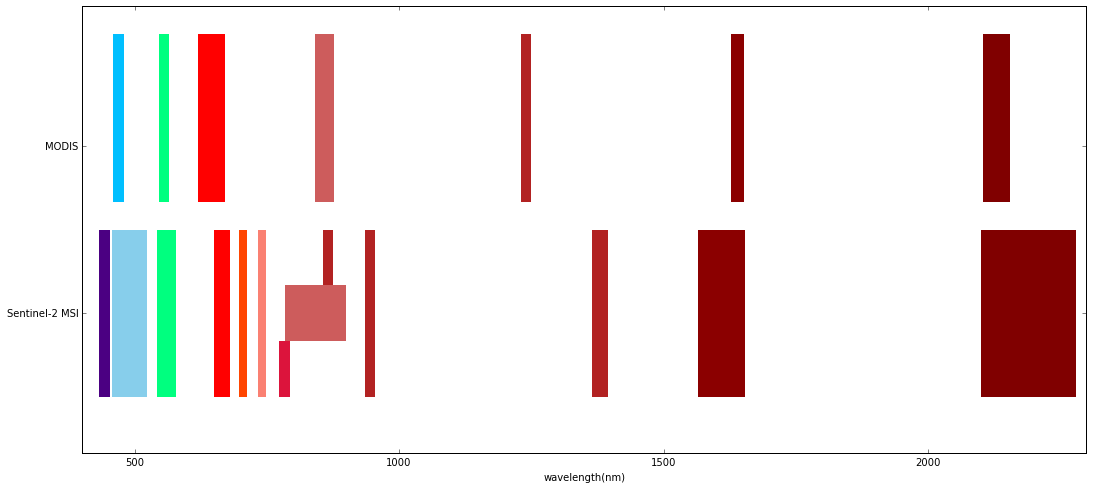

In [27]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

fig,ax = plt.subplots(figsize=(18,8))
#ax.broken_barh(cb, (9.75, 0.25), facecolors=cs)
ax.broken_barh(sb[:6], (1, 3), facecolors=('indigo', 'skyblue','springgreen','red',
                                       'orangered','salmon','crimson','indianred','firebrick',
                                       'firebrick','firebrick','darkred','maroon'),linewidth = 0)
ax.broken_barh(sb[6:7], (1, 1), facecolors='crimson', linewidth = 0)
ax.broken_barh(sb[7:8], (2, 1), facecolors='indianred', cmap = cmap,  linewidth = 0)
ax.broken_barh(sb[8:9], (3, 1), facecolors='firebrick', linewidth = 0)
ax.broken_barh(sb[9:], (1, 3), facecolors=('firebrick','firebrick','darkred','maroon'), linewidth = 0)

ax.broken_barh(mb, (4.5, 3),facecolors=('deepskyblue','springgreen','red','indianred', 
                                        'firebrick','darkred','maroon'), linewidth = 0)
ax.set_ylim(0, 8)
ax.set_xlim(400, 2300)
ax.set_xlabel('wavelength(nm)')
ax.set_yticks([2.5, 5.5])
ax.set_yticklabels(['Sentinel-2 MSI', 'MODIS'])
ax.grid(False)

#cbaxes = fig.add_axes([1,-1,0,0.01]) 
#s = plt.colorbar(ax, cax = cbaxes)

From this img we can see that the corresponding bands are 2,3,4,8,8a,11,12 for sentinel2 and 1,2,3,4,6,7 for MODIS and sentinel 8 and 8a corresponding to the same band 5 of MODIS.

In [9]:
import pylab as plt
%matplotlib inline
#plt.plot(np.unique(px))

In [355]:
import pylab as plt
plt.figure(figsize=(15,15))
plt.imshow(p_lat, interpolation = 'none')

In [228]:
m.toLatLon('50SMH')

(37.942085319765845, 115.86192606806833)

In [224]:
m.toLatLon('50SMG')

(37.040893542510126, 115.87551977006001)

In [225]:
m.toLatLon('50SNG')

(37.04622247590853, 117.0)

In [227]:
m.toLatLon('50SNH')

(37.94758957178304, 117.0)

### MODIS BRDF and Sentinel 2 TOA reflectance comparison

In [60]:
import gdal
import sys
sys.path.insert(0,'python')
from fast_rw import *

In [61]:
import glob
modis_files = glob.glob('m_data/MCD43A*.A2016105.h27v05.005.*.hdf')

In [62]:
modis_files

['m_data/MCD43A1.A2016105.h27v05.005.2016122100738.hdf',
 'm_data/MCD43A2.A2016105.h27v05.005.2016122100739.hdf',
 'm_data/MCD43A3.A2016105.h27v05.005.2016122100739.hdf']

In [298]:
modis_filenames = gdal.Open('m_data/MCD43A1.A2016105.h27v05.005.2016122100738.hdf').GetSubDatasets()
modis_filenames

[('HDF4_EOS:EOS_GRID:"m_data/MCD43A1.A2016105.h27v05.005.2016122100738.hdf":MOD_Grid_BRDF:BRDF_Albedo_Parameters_Band1',
  '[2400x2400x3] BRDF_Albedo_Parameters_Band1 MOD_Grid_BRDF (16-bit integer)'),
 ('HDF4_EOS:EOS_GRID:"m_data/MCD43A1.A2016105.h27v05.005.2016122100738.hdf":MOD_Grid_BRDF:BRDF_Albedo_Parameters_Band2',
  '[2400x2400x3] BRDF_Albedo_Parameters_Band2 MOD_Grid_BRDF (16-bit integer)'),
 ('HDF4_EOS:EOS_GRID:"m_data/MCD43A1.A2016105.h27v05.005.2016122100738.hdf":MOD_Grid_BRDF:BRDF_Albedo_Parameters_Band3',
  '[2400x2400x3] BRDF_Albedo_Parameters_Band3 MOD_Grid_BRDF (16-bit integer)'),
 ('HDF4_EOS:EOS_GRID:"m_data/MCD43A1.A2016105.h27v05.005.2016122100738.hdf":MOD_Grid_BRDF:BRDF_Albedo_Parameters_Band4',
  '[2400x2400x3] BRDF_Albedo_Parameters_Band4 MOD_Grid_BRDF (16-bit integer)'),
 ('HDF4_EOS:EOS_GRID:"m_data/MCD43A1.A2016105.h27v05.005.2016122100738.hdf":MOD_Grid_BRDF:BRDF_Albedo_Parameters_Band5',
  '[2400x2400x3] BRDF_Albedo_Parameters_Band5 MOD_Grid_BRDF (16-bit integer

In [336]:
modisQA = gdal.Open("m_data/MCD43A2.A2016105.h27v05.005.2016122100739.hdf").GetSubDatasets()
modisQA

[('HDF4_EOS:EOS_GRID:"m_data/MCD43A2.A2016105.h27v05.005.2016122100739.hdf":MOD_Grid_BRDF:BRDF_Albedo_Quality',
  '[2400x2400] BRDF_Albedo_Quality MOD_Grid_BRDF (8-bit unsigned integer)'),
 ('HDF4_EOS:EOS_GRID:"m_data/MCD43A2.A2016105.h27v05.005.2016122100739.hdf":MOD_Grid_BRDF:Snow_BRDF_Albedo',
  '[2400x2400] Snow_BRDF_Albedo MOD_Grid_BRDF (8-bit unsigned integer)'),
 ('HDF4_EOS:EOS_GRID:"m_data/MCD43A2.A2016105.h27v05.005.2016122100739.hdf":MOD_Grid_BRDF:BRDF_Albedo_Ancillary',
  '[2400x2400] BRDF_Albedo_Ancillary MOD_Grid_BRDF (16-bit unsigned integer)'),
 ('HDF4_EOS:EOS_GRID:"m_data/MCD43A2.A2016105.h27v05.005.2016122100739.hdf":MOD_Grid_BRDF:BRDF_Albedo_Band_Quality',
  '[2400x2400] BRDF_Albedo_Band_Quality MOD_Grid_BRDF (32-bit unsigned integer)')]

In [66]:
def r_modis(fname):
    g = gdal.Open(fname)
    if g is None:
        raise IOError
    else:
        return g.ReadAsArray()

In [67]:
Alats,Alons

(array([[494, 494, 494, ..., 493, 493, 493],
        [494, 494, 494, ..., 493, 493, 493],
        [494, 494, 494, ..., 493, 493, 493],
        ..., 
        [711, 711, 711, ..., 709, 709, 709],
        [711, 711, 711, ..., 709, 709, 709],
        [711, 711, 711, ..., 709, 709, 709]]),
 array([[330, 330, 330, ..., 544, 544, 544],
        [330, 330, 330, ..., 544, 544, 544],
        [330, 330, 330, ..., 544, 544, 544],
        ..., 
        [599, 599, 599, ..., 812, 812, 812],
        [599, 599, 599, ..., 812, 812, 812],
        [599, 599, 599, ..., 812, 812, 813]]))

In [68]:
b1_brdf = r_modis(modis_filenames[1][0])

In [290]:
b3_brdf = r_modis(modis_filenames[3][0])

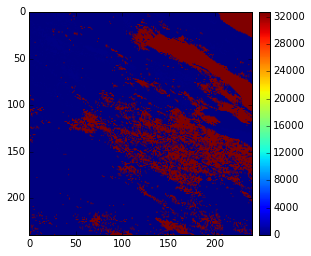

In [291]:
dimg(b3_brdf[0], step =10)

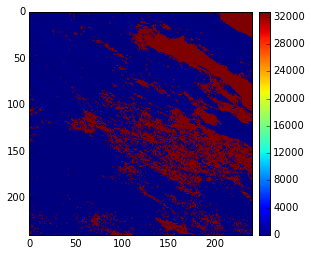

In [73]:
%matplotlib inline
import sys
sys.path.insert(0, 'python')
from dimg import dimg
dimg(b1_brdf[0], step =10)

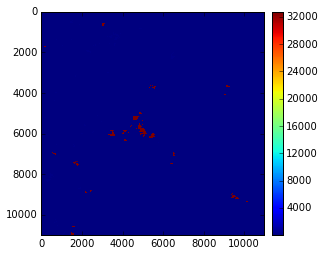

In [292]:
dimg(b3_brdf[0][Alats,Alons])

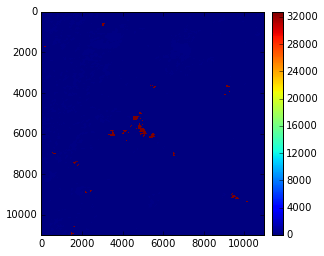

In [74]:
dimg(b1_brdf[0][Alats,Alons])

In [75]:
b1_QA = r_modis(modis_bandQA[0][0])

In [337]:
b3_QA = r_modis(modis_bandQA[0][0])

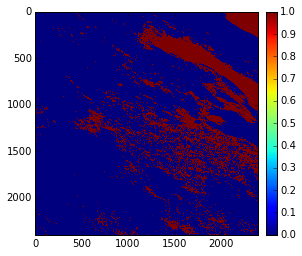

In [76]:
import numpy.ma as ma
mask = b1_QA>1
dimg(mask)

In [77]:
brdf_m = (b1_brdf[0] > 32766) | (b1_brdf[1] > 32766) |(b1_brdf[2] > 32766)

In [293]:
brdf3_m = (b3_brdf[0] > 32766) | (b3_brdf[1] > 32766) |(b3_brdf[2] > 32766)

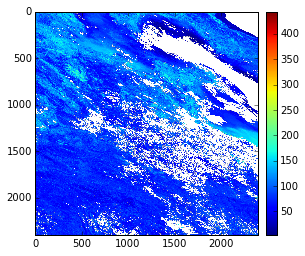

In [294]:
dimg(ma.array(b3_brdf[0], mask = mask|brdf3_m))

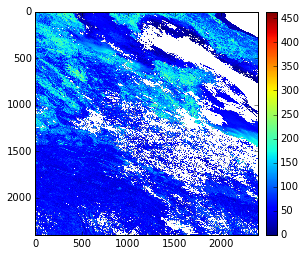

In [78]:
dimg(ma.array(b1_brdf[0], mask = mask|brdf_m))

In [338]:
mb3_brdf = []
for i in range(3):
    mb3_brdf.append(ma.array(b3_brdf[i], mask = (b3_QA>1)|brdf3_m))

In [79]:
mb1_brdf = []
for i in range(3):
    mb1_brdf.append(ma.array(b1_brdf[i], mask = (b1_QA>1)|brdf_m))

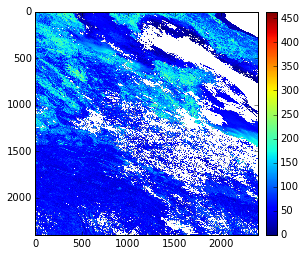

In [80]:
dimg(mb1_brdf[0])

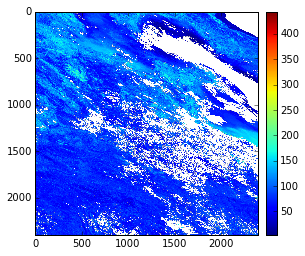

In [339]:
dimg(mb3_brdf[0])

In [340]:
mb3_brdf[0]

masked_array(data =
 [[126 108 92 ..., -- -- --]
 [113 124 117 ..., -- -- --]
 [118 120 125 ..., -- -- --]
 ..., 
 [86 76 85 ..., 80 99 105]
 [78 76 76 ..., -- 79 89]
 [79 78 76 ..., -- -- --]],
             mask =
 [[False False False ...,  True  True  True]
 [False False False ...,  True  True  True]
 [False False False ...,  True  True  True]
 ..., 
 [False False False ..., False False False]
 [False False False ...,  True False False]
 [False False False ...,  True  True  True]],
       fill_value = 999999)

In [89]:
mb1_brdf[0]

masked_array(data =
 [[161 133 110 ..., -- -- --]
 [148 155 135 ..., -- -- --]
 [150 145 153 ..., -- -- --]
 ..., 
 [75 67 73 ..., 62 93 98]
 [71 68 67 ..., -- 64 91]
 [74 75 75 ..., -- -- --]],
             mask =
 [[False False False ...,  True  True  True]
 [False False False ...,  True  True  True]
 [False False False ...,  True  True  True]
 ..., 
 [False False False ..., False False False]
 [False False False ...,  True False False]
 [False False False ...,  True  True  True]],
       fill_value = 999999)

In [327]:
mb1_brdf = ma.array(mb1_brdf)

In [90]:
(mb1_brdf[0])[Alats,Alons]

masked_array(data =
 [[127 127 127 ..., 65 65 65]
 [127 127 127 ..., 65 65 65]
 [127 127 127 ..., 65 65 65]
 ..., 
 [76 76 76 ..., 54 54 54]
 [76 76 76 ..., 54 54 54]
 [76 76 76 ..., 54 54 54]],
             mask =
 [[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]],
       fill_value = 999999)

In [341]:
mb3_brdf[0][Alats,Alons]

masked_array(data =
 [[108 108 108 ..., 68 68 68]
 [108 108 108 ..., 68 68 68]
 [108 108 108 ..., 68 68 68]
 ..., 
 [68 68 68 ..., 62 62 62]
 [68 68 68 ..., 62 62 62]
 [68 68 68 ..., 62 62 60]],
             mask =
 [[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]],
       fill_value = 999999)

In [342]:
paras3 = ma.array([mb3_brdf[i][Alats,Alons] for i in range(3)])

In [91]:
paras = ma.array([mb1_brdf[i][Alats,Alons] for i in range(3)])

In [92]:
paras.shape

(3, 10980, 10980)

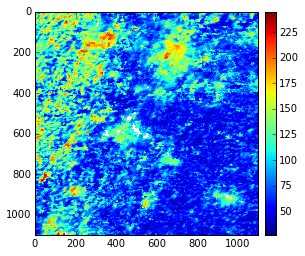

In [111]:
dimg(paras[0], step=10)

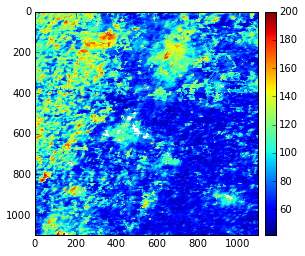

In [343]:
dimg(paras3[0],step=10)

In [96]:
# read in the corresponding band
from readSent import *
co_bands = readfile([2,3,4,8,13,11,12], 'data/50SMG20164100', bounds =None)

data/50SMG20164100auxiliaryECMWFT
data/50SMG20164100metadata.xml


In [97]:
vZa = np.nanmean(co_bands['VIAG_Z'].reshape(12,13,23,23), axis = 0)

In [98]:
vAa = np.nanmean(co_bands['VIAG_A'].reshape(12,13,23,23), axis = 0)

/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


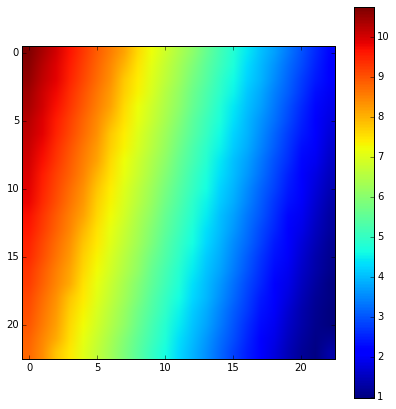

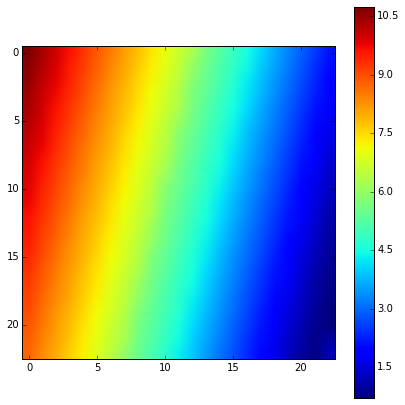

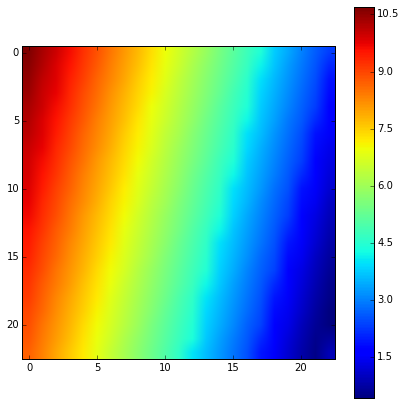

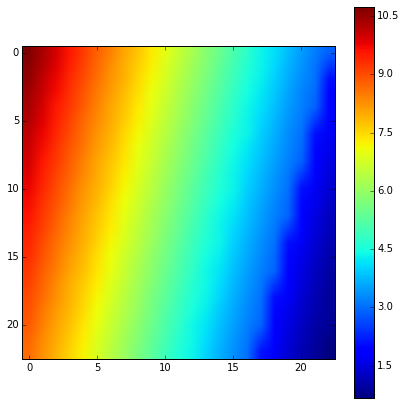

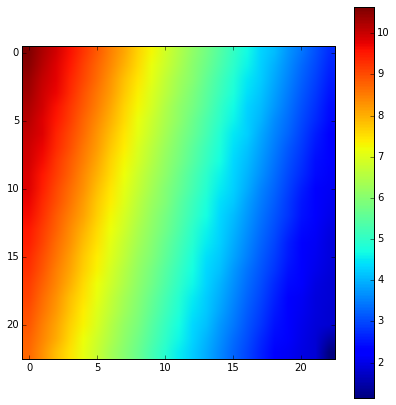

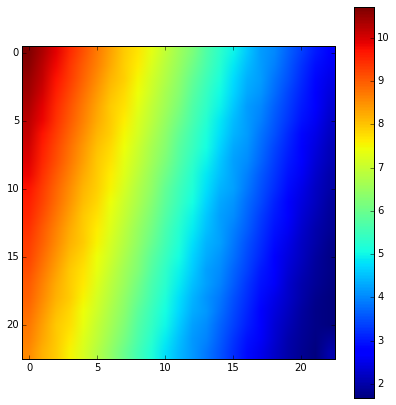

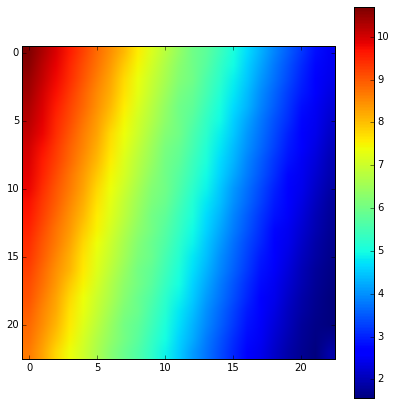

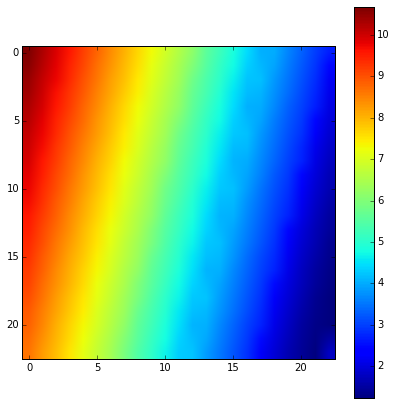

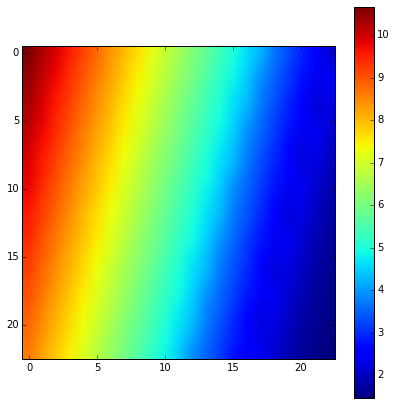

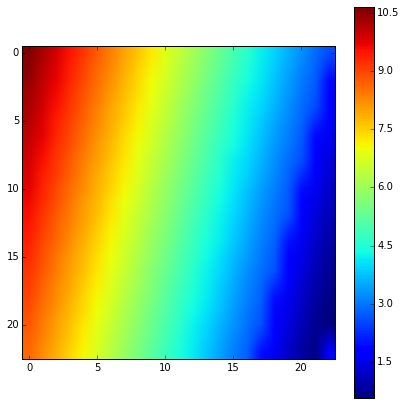

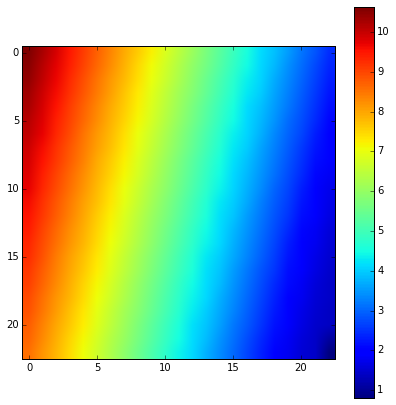

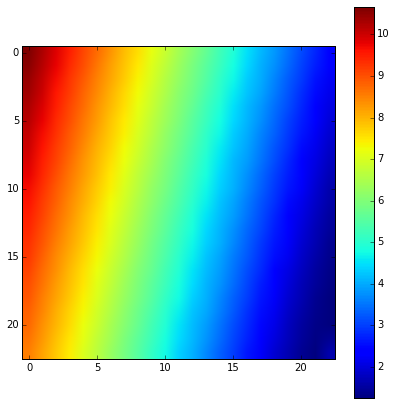

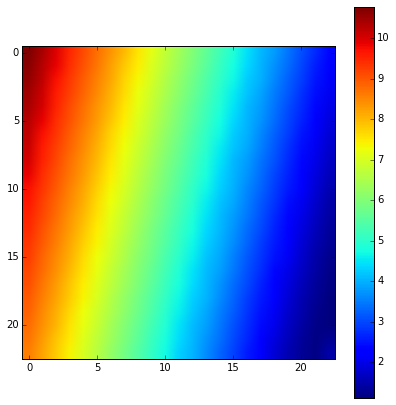

In [29]:
# bands view azimuth angle
import pylab as plt
%matplotlib inline

for i in range(13):
    figure = plt.figure(figsize = (7,7))
    plt.imshow(vAa[i]) 
    plt.colorbar()

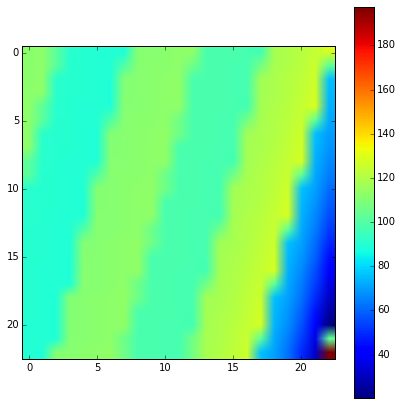

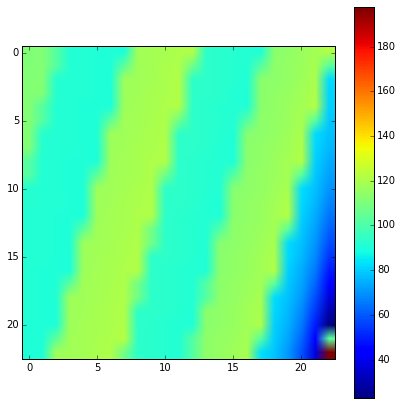

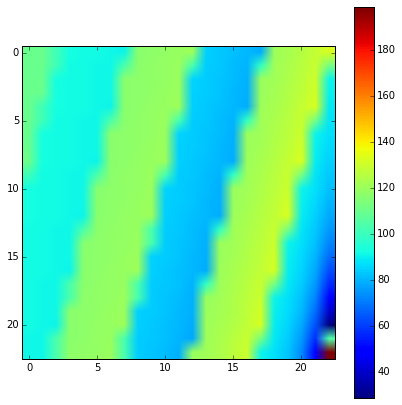

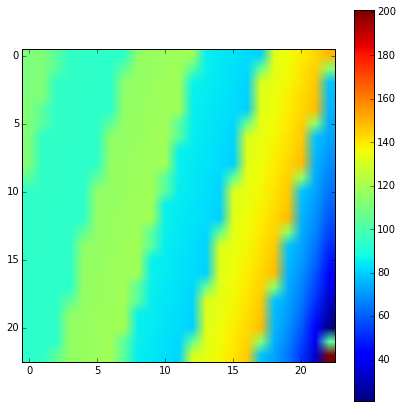

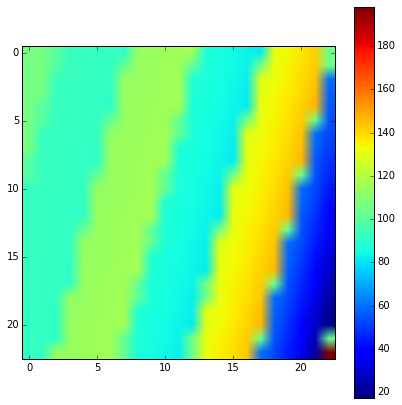

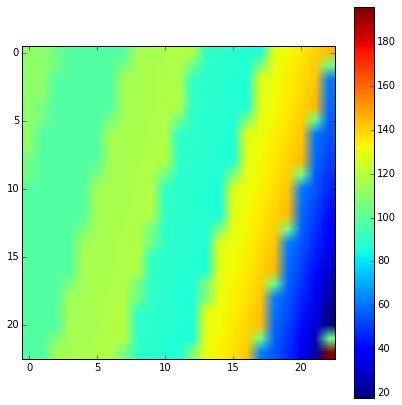

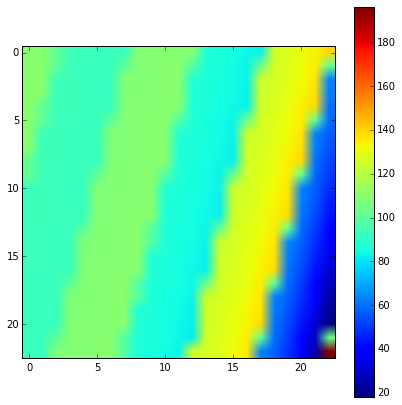

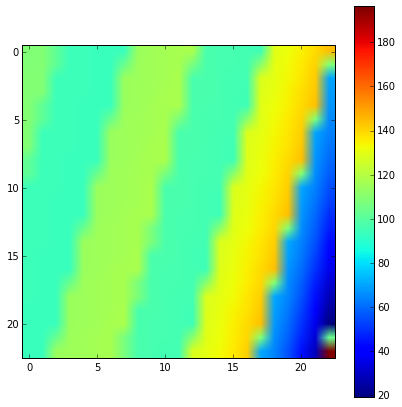

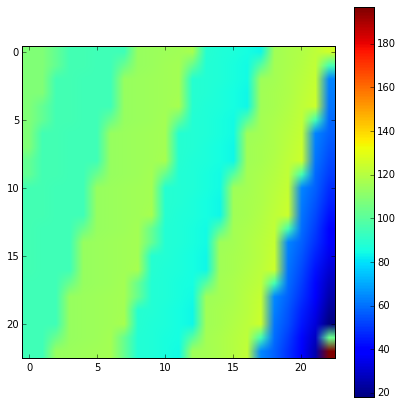

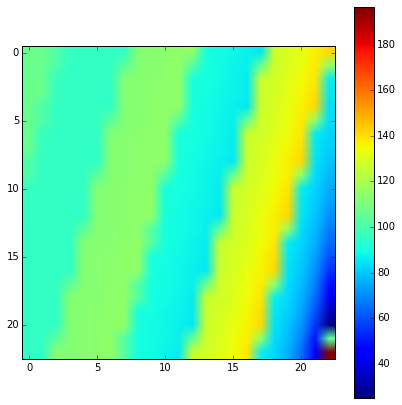

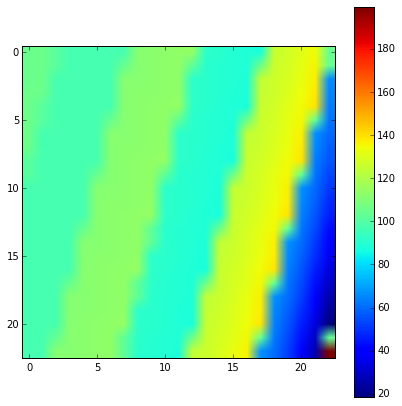

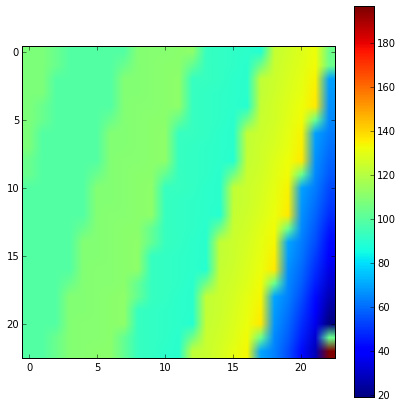

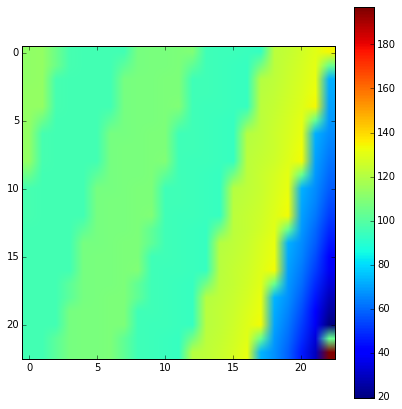

In [32]:
for i in range(13):
    plt.imshow(vZa[i]) 
    plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7fa18dcc5f80>

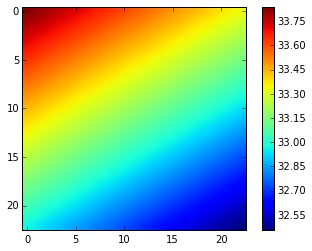

In [64]:
plt.imshow(b1['SAG_A'])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7fa192bcd638>

/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


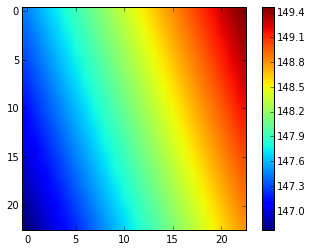

In [63]:
plt.imshow(b1['SAG_Z'])
plt.colorbar()

In [99]:
co_bands.keys()

['TCO3',
 'VIAG_Z',
 'MSLP',
 'mSz',
 'SAG_Z',
 'mVz',
 'TCWV',
 'SAG_A',
 'VIAG_A',
 'mVa',
 'B03',
 'B02',
 'B12',
 'B04',
 'B11',
 'B8A',
 'B08',
 'mSa']

In [84]:
'''
data = {'sZa':b1['mSz'], 'vZa': b1['mVz'][1], 'relative_azimuth': b1['mSa']-b1['mVa'][1] , 
        'b': 1., 'r': 1., 'h': 2.,'f_iso':paras[0].reshape(10980,10980), 
        'f_vol': paras[1].reshape(10980,10980), 'f_geo':paras[2].reshape(10980,10980)}
import numpy as np
def BRDF_adjust(data):
    sZa = data['sZa']; vZa = data['vZa']; relative_azimuth = data['relative_azimuth']; h = data['h']
    b = data['b']; r = data['r']; f_iso = data['f_iso']; f_vol = data['f_vol']; f_geo = data['f_geo']
    
    phase_angle = np.arccos(np.cos(sZa)*np.cos(vZa) + np.sin(sZa)*np.sin(vZa)*np.cos(relative_azimuth))
    theta = np.arctan((b/r)*np.tan(sZa))
    phi = np.arctan((b/r)*np.tan(vZa))
    D = np.sqrt((np.tan(theta))**2. + (np.tan(phi))**2. - 2.*np.tan(theta)*np.tan(phi)*np.cos(relative_azimuth))
    phase_angle2 = np.arccos(np.cos(theta)*np.cos(phi) + np.sin(theta)*np.sin(phi)*np.cos(relative_azimuth))
    t = np.arccos((h/b)*np.sqrt(D**2 + (np.tan(theta)*np.tan(phi)*
                                        np.sin(relative_azimuth))**2)/((np.cos(theta))**-1 + (np.cos(phi))**-1))
    
                  
    
    O = (1/np.pi)*(t - np.sin(t)*np.cos(t))*((np.cos(theta))**-1 + (np.cos(phi))**-1)
    k_vol = ((np.pi/2.-phase_angle)*np.cos(phase_angle) + np.sin(phase_angle))/(np.cos(sZa)+np.cos(vZa)) - (np.pi)/4.
    k_geo = O - ((np.cos(theta))**-1) - ((np.cos(phi))**-1) + 0.5*(1.+np.cos(phase_angle2))*((np.cos(theta))**-1)*((np.cos(phi))**-1)
    
    R = f_iso + f_vol*k_vol + f_geo*k_geo
    
    return R
'''

In [100]:
# get the angle adjusted kernels to correct the brdf to the angle of sentinel 2 
import sys
sys.path.insert(0,'python')
import kernels

In [101]:
def ScaleExtent(data): # used for unifine different array, 
    shape = (10980,10980)
    re = int(shape[0]/(data.shape[0]))
    return np.repeat(np.repeat(data, re, axis = 1), re, axis =0)

In [102]:
kk = kernels.Kernels(vZa[1] , co_bands['SAG_Z'],co_bands['SAG_A']-vAa[1],\
                     RossHS=False,MODISSPARSE=True,\
                     RecipFlag=True,normalise=1,\
                     doIntegrals=False,LiType='Dense',RossType='Thick')

In [103]:
ross = kk.Ross
li   = kk.Li
iso =  kk.Isotropic
k_vol = ScaleExtent(ross); k_geo = ScaleExtent(li)

In [104]:
k_vol.shape

(10971, 10971)

In [105]:
a = np.zeros((10980,10980))
a[:10971,:10971] = k_vol
a[10971:,10971:] = k_vol[-9:,-9:]
k_vol = a
a[:10971,:10971] = k_geo
a[10971:,10971:] = k_geo[-9:,-9:]
k_geo = a

In [106]:
paras

masked_array(data =
 [[[127 127 127 ..., 65 65 65]
  [127 127 127 ..., 65 65 65]
  [127 127 127 ..., 65 65 65]
  ..., 
  [76 76 76 ..., 54 54 54]
  [76 76 76 ..., 54 54 54]
  [76 76 76 ..., 54 54 54]]

 [[0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]

 [[33 33 33 ..., 0 0 0]
  [33 33 33 ..., 0 0 0]
  [33 33 33 ..., 0 0 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]],
             mask =
 [[[False False False ..., False False False]
  [False False False ..., False False False]
  [False False False ..., False False False]
  ..., 
  [False False False ..., False False False]
  [False False False ..., False False False]
  [False False False ..., False False False]]

 [[False False False ..., False False False]
  [False False False ..., False False False]
  [False False False ..., False False False]
  ..., 
  [False False False ..., False False False]
  [False False False ..., F

In [344]:
R3 = paras3[0] + paras3[1]*k_vol + paras3[2]*k_geo

In [112]:
R2 = paras[0] + paras[1]*k_vol + paras[2]*k_geo

In [194]:
R = paras[0].reshape(10980,10980) + paras[1].reshape(10980,10980)*k_vol + paras[2].reshape(10980,10980)*k_geo

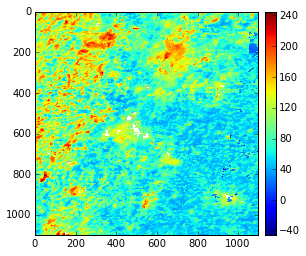

In [113]:
dimg(R2, step=10)

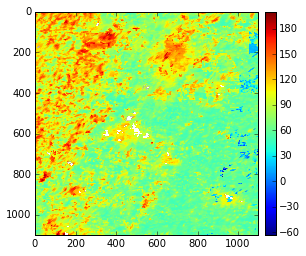

In [346]:
dimg(R3,step=10)

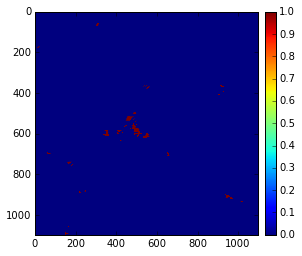

In [114]:
dimg(R2.mask, step=10)

In [347]:
zero_mask3 = R3<0
b3_brdf = ma.array(R3.data, mask = R3.mask|zero_mask3)

In [115]:
zero_mask = R2<0
b1_brdf2 = ma.array(R2.data, mask = R2.mask|zero_mask)

In [210]:
zero_mask = R<0
b1_brdf = ma.array(R.data, mask = R.mask|zero_mask)

In [1]:
dimg(small*0.001)

NameError: name 'dimg' is not defined

In [494]:
small2 = sent_b2.reshape([Nsmall, Nbig/Nsmall, Nsmall, Nbig/Nsmall]).mean(3).mean(1)

In [500]:
mask = small1.mask | small2.mask

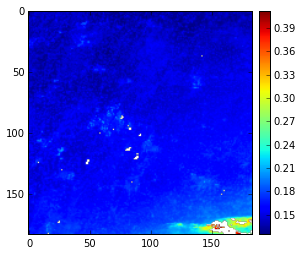

In [492]:
dimg(small)

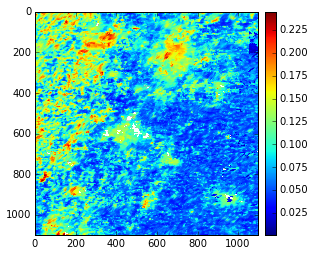

In [117]:
dimg(b1_brdf2*0.001, step=10)

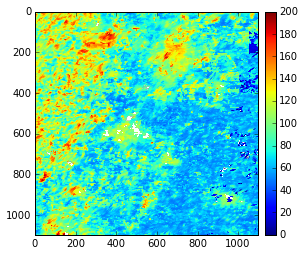

In [348]:
dimg(b3_brdf, step=10)

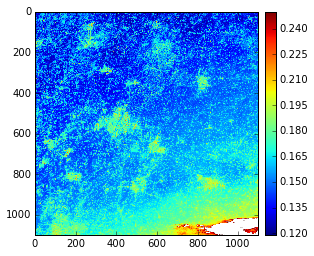

In [137]:
dimg(ma.array(co_bands['B02'], mask = co_bands['B02']>0.25), step=10)

In [118]:
import cPickle as pkl
vm = pkl.load(open('pkls/vm.pkl'))

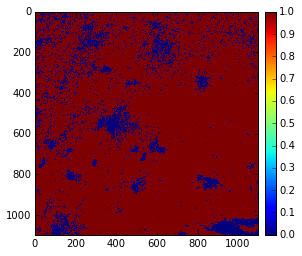

In [119]:
dimg(vm, step = 10)

In [120]:
w_p = np.where(vm)
a = np.arange(len(w_p[0]))
px = []
py = []
for i in range(100000):
    ind = np.random.choice(a)
    px.append(w_p[0][ind])
    py.append(w_p[1][ind])

In [270]:
sent_b2 = ma.array(co_bands['B02'], mask = ~vm|b1_brdf2.mask)
brdf_b1 = ma.array(b1_brdf2.data, mask = ~vm|b1_brdf2.mask)

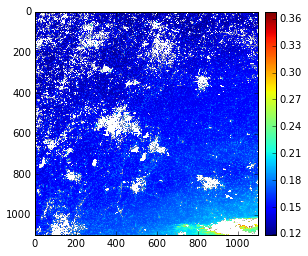

In [271]:
dimg(sent_b2, step=10)

In [349]:
sent2cut = sent_b2[:-750, :-700]
brdf3cut = (b3_brdf.data)[750:,700:]
vmcut = vm[:-750, :-700]
bm3cut = (b3_brdf.mask)[750:,700:]

In [272]:
sentcut = sent_b2[:-750, :-700]
brdfcut = (brdf_b1)[750:,700:]
vmcut = vm[:-750, :-700]
bmcut = (R2.mask|zero_mask)[750:,700:]

In [273]:
sentcut.shape,brdfcut.shape

((10230, 10280), (10230, 10280))

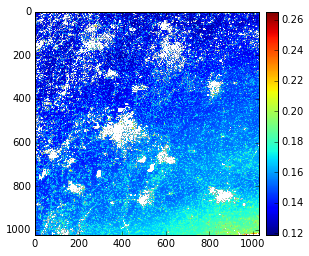

In [274]:
dimg(ma.array(sentcut.data, mask=~vmcut|bmcut),step=10)

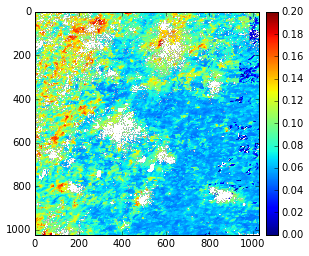

In [351]:
dimg(ma.array(brdf3cut*0.001,mask=~vmcut|bm3cut),step=10)

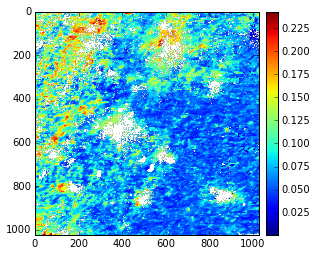

In [275]:
dimg(ma.array(brdfcut.data*0.001,mask=~vmcut|bmcut),step=10)

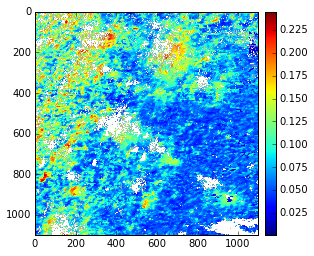

In [276]:
dimg((brdf_b1*0.0010), step=10)

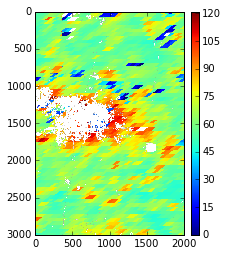

In [354]:
dimg(ma.array(brdf3cut,mask=~vmcut|bm3cut)[7000:10000, 8000:10000])

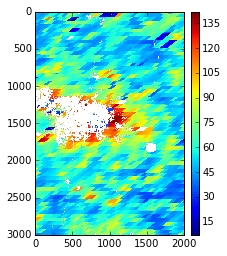

In [277]:
dimg(ma.array(brdfcut.data,mask=~vmcut|bmcut)[7000:10000, 8000:10000])

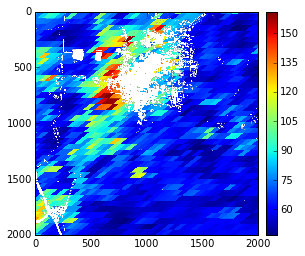

In [352]:
dimg(ma.array(brdf3cut, mask=~vmcut|bm3cut)[8000:10000, 4000:6000])

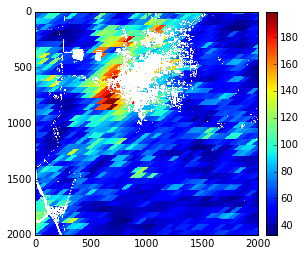

In [278]:
dimg(ma.array(brdfcut.data,mask=~vmcut|bmcut)[8000:10000, 4000:6000])

In [355]:
csent_b2 = ma.array(sent2cut, mask=~vmcut|bm3cut)
cbrdf_b3 = ma.array(brdf3cut, mask=~vmcut|bm3cut)

In [279]:
csent_b2 = ma.array(sentcut.data, mask=~vmcut|bmcut)
cbrdf_b1 = ma.array(brdfcut.data,mask=~vmcut|bmcut)

In [ ]:
# a uniform (boxcar) filter with a width of 50
Bboxcar = ndimage.uniform_filter(cbrdf_b3, 50)

# a uniform (boxcar) filter with a width of 50
Sboxcar = ndimage.uniform_filter(csent_b2*(~csent_b2.mask), 50)


In [398]:
from scipy import ndimage
from scipy.misc import lena

# a Gaussian filter with a standard deviation of 10
Sgauss = ndimage.gaussian_filter(csent_b2*(~csent_b2.mask), 50)

In [399]:

# a Gaussian filter with a standard deviation of 10
Bgauss = ndimage.gaussian_filter(cbrdf_b3*(~cbrdf_b3.mask), 50)

In [416]:
import numpy

x = numpy.array([1, 2, 3, 4, 5, 6])

numpy.mean(x.reshape(-1, 2), 1) 

array([ 1.5,  3.5,  5.5])

In [420]:
def average(arr, n):
    end =  n * int(len(arr)/n)
    return numpy.mean(arr[:end].reshape(-1, n), 1)

In [ ]:
reshape(-1, n)

In [430]:
a = np.arange(100).reshape(10,10)
a

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

In [477]:
Nbig = 10
Nsmall = 5
big = np.arange(100).reshape([10,10])

small = big.reshape([Nsmall, Nbig/Nsmall, Nsmall, Nbig/Nsmall]).mean(3).mean(1)

In [478]:
small

array([[  5.5,   7.5,   9.5,  11.5,  13.5],
       [ 25.5,  27.5,  29.5,  31.5,  33.5],
       [ 45.5,  47.5,  49.5,  51.5,  53.5],
       [ 65.5,  67.5,  69.5,  71.5,  73.5],
       [ 85.5,  87.5,  89.5,  91.5,  93.5]])

In [400]:
Sgauss

array([[ 0.13916295,  0.13917598,  0.139201  , ...,  0.13016467,
         0.13007226,  0.13002601],
       [ 0.13916278,  0.13917588,  0.13920103, ...,  0.13017148,
         0.13007917,  0.13003298],
       [ 0.13916227,  0.13917549,  0.13920092, ...,  0.13018524,
         0.13009315,  0.13004705],
       ..., 
       [ 0.15105583,  0.15104721,  0.1510301 , ...,  0.33485653,
         0.3349065 ,  0.33493134],
       [ 0.15110513,  0.15109633,  0.15107885, ...,  0.33515543,
         0.33520671,  0.33523219],
       [ 0.15113011,  0.15112121,  0.15110355, ...,  0.33530525,
         0.33535718,  0.33538299]])

In [401]:
Bgauss

array([[ 153.17331206,  153.15248297,  153.11071242, ...,   67.39419799,
          67.39098777,   67.38951994],
       [ 153.16258211,  153.14166483,  153.0997207 , ...,   67.41400551,
          67.4111664 ,   67.40988512],
       [ 153.14156166,  153.12047414,  153.07819509, ...,   67.45408885,
          67.45199426,   67.45108725],
       ..., 
       [  97.70266813,   97.68551608,   97.65131657, ...,   61.98217827,
          61.98239119,   61.98249222],
       [  97.64251174,   97.625112  ,   97.59042074, ...,   61.98263   ,
          61.98280063,   61.98288057],
       [  97.61202274,   97.59449779,   97.55955797, ...,   61.98284822,
          61.98299785,   61.98306732]])

In [394]:
Sgauss

array([[ 0.13916295,  0.13917598,  0.139201  , ...,  0.13016467,
         0.13007226,  0.13002601],
       [ 0.13916278,  0.13917588,  0.13920103, ...,  0.13017148,
         0.13007917,  0.13003298],
       [ 0.13916227,  0.13917549,  0.13920092, ...,  0.13018524,
         0.13009315,  0.13004705],
       ..., 
       [ 0.15105583,  0.15104721,  0.1510301 , ...,  0.33485653,
         0.3349065 ,  0.33493134],
       [ 0.15110513,  0.15109633,  0.15107885, ...,  0.33515543,
         0.33520671,  0.33523219],
       [ 0.15113011,  0.15112121,  0.15110355, ...,  0.33530525,
         0.33535718,  0.33538299]])

In [397]:
Bboxcar*0.001

array([[ 0.1507952,  0.150784 ,  0.1507616, ...,  0.0675784,  0.0675448,
         0.067528 ],
       [ 0.150812 ,  0.1508008,  0.1507784, ...,  0.0676024,  0.0675688,
         0.067552 ],
       [ 0.1508624,  0.1508512,  0.1508288, ...,  0.0676984,  0.0676648,
         0.067648 ],
       ..., 
       [ 0.0985984,  0.0985936,  0.098584 , ...,  0.0619496,  0.0619544,
         0.0619568],
       [ 0.0985984,  0.0985936,  0.098584 , ...,  0.0619576,  0.0619632,
         0.0619664],
       [ 0.0985984,  0.0985936,  0.098584 , ...,  0.0619632,  0.0619696,
         0.0619728]])

In [392]:
Bgauss*0.001

array([[ 0.15317331,  0.15315248,  0.15311071, ...,  0.0673942 ,
         0.06739099,  0.06738952],
       [ 0.15316258,  0.15314166,  0.15309972, ...,  0.06741401,
         0.06741117,  0.06740989],
       [ 0.15314156,  0.15312047,  0.1530782 , ...,  0.06745409,
         0.06745199,  0.06745109],
       ..., 
       [ 0.09770267,  0.09768552,  0.09765132, ...,  0.06198218,
         0.06198239,  0.06198249],
       [ 0.09764251,  0.09762511,  0.09759042, ...,  0.06198263,
         0.0619828 ,  0.06198288],
       [ 0.09761202,  0.0975945 ,  0.09755956, ...,  0.06198285,
         0.061983  ,  0.06198307]])

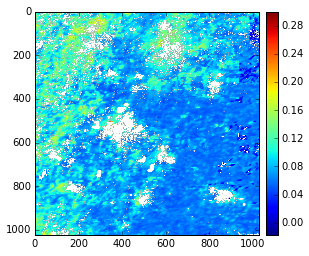

In [409]:
dimg(ma.array(Bgauss*0.001,mask= cbrdf_b3.mask |(Bgauss>300)) , step=10)

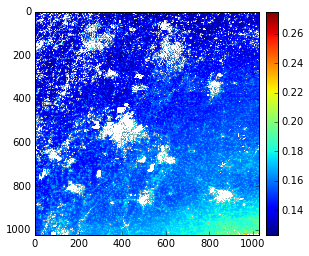

In [406]:
dimg(ma.array(Sgauss,mask= cbrdf_b3.mask |(Bgauss>300)), step=10)

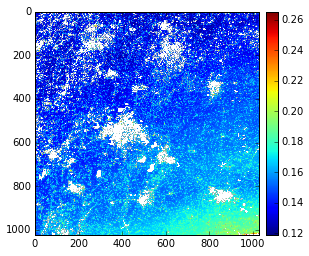

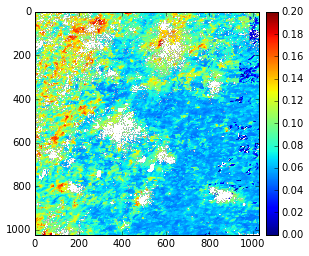

In [371]:

dimg(csent_b2, step=10)
dimg(cbrdf_b3*0.001,step=10)

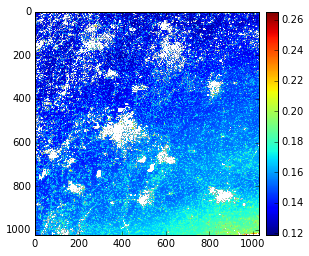

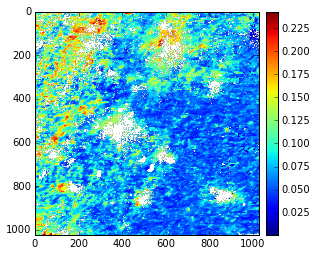

In [280]:
dimg(csent_b2, step=10)
dimg(cbrdf_b1*0.001,step=10)

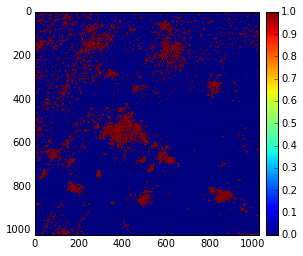

In [379]:
dimg(csent_b2.mask, step=10)

In [411]:
rand_sent_b2 = ma.compressed(ma.array(Sgauss,mask= cbrdf_b3.mask |(Bgauss>300)))
rand_brdf_b1 = ma.compressed(ma.array(Bgauss*0.001,mask= cbrdf_b3.mask |(Bgauss>300)))

In [413]:
rand_sent_b2,rand_brdf_b1  

(array([ 0.13916295,  0.13917598,  0.139201  , ...,  0.24374242,
         0.24452544,  0.31954171]),
 array([ 0.15317331,  0.15315248,  0.15311071, ...,  0.06379298,
         0.06365233,  0.06133641]))

In [358]:
#rand_sent_b2 = ma.array(rand_sent_b2, mask = rand_brdf_b1.mask)
rand_sent_b2 = ma.compressed(csent_b2)
rand_brdf_b1 = ma.compressed(cbrdf_b3)

In [360]:
rand_sent_b2 = co_bands['B02'][px, py]
rand_brdf_b1 = b1_brdf2[px, py]

In [281]:
#rand_sent_b2 = ma.array(rand_sent_b2, mask = rand_brdf_b1.mask)
rand_sent_b2 = ma.compressed(csent_b2)
rand_brdf_b1 = ma.compressed(cbrdf_b1)

In [361]:
len(rand_brdf_b1)

100000

In [362]:
len(rand_sent_b2)

100000

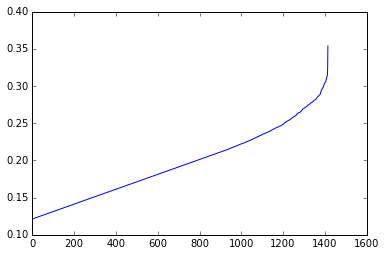

In [365]:
import pylab as plt
plt.plot(np.unique(rand_sent_b2))

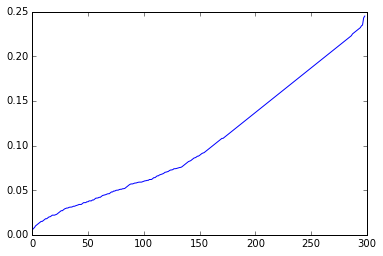

In [366]:
plt.plot(np.unique(rand_brdf_b1*0.0010))

In [415]:
import scipy.stats
scipy.stats.linregress(rand_brdf_b1, rand_sent_b2)

LinregressResult(slope=-0.15233783678774429, intercept=0.1657155077925562, rvalue=-0.30200387573819532, pvalue=0.0, stderr=5.0166669840581914e-05)

In [287]:
m,b = np.polyfit( (rand_brdf_b1*0.001),rand_sent_b2, 1)

In [ ]:
fit = np.polyfit( rand_brdf_b1*0.001,rand_sent_b2, 1)
fit_fn = np.poly1d(fit)
# fit_fn is now a function which takes in x and returns an estimate for y
plt.plot(rand_brdf_b1*0.001,rand_sent_b2,  'yo',rand_brdf_b1*0.001 , fit_fn(rand_sent_b2), '--k')

In [167]:
m,b = np.polyfit(R.ravel(), b1['B02'].ravel(), 1)

In [168]:
m,b

(0.00012773166302347679, 0.15443156487893256)

In [166]:
R.ravel()[R.ravel()< 0]=0
R.ravel()[R.ravel()>100] = 0

In [170]:
coords = []
for i in range(1000):
    x = np.random.choice(10980)
    y = np.random.choice(10980)
    coords.append([x,y])

In [ ]:
fit = np.polyfit(R[coords[0], coords[1]].ravel(), b1['B02'][coords[0], coords[1]].ravel(), 1)
fit_fn = np.poly1d(fit)
# fit_fn is now a function which takes in x and returns an estimate for y
plt.plot(R[coords[0], coords[1]].ravel(), b1['B02'][coords[0], coords[1]].ravel(), 'yo', R[coords[0], coords[1]].ravel(), fit_fn(R[coords[0], coords[1]].ravel()), '--k')

In [158]:
b1['B02']

array([[ 0.1284,  0.129 ,  0.1292, ...,  0.1645,  0.169 ,  0.1619],
       [ 0.1281,  0.1291,  0.1297, ...,  0.1536,  0.1606,  0.1607],
       [ 0.127 ,  0.1294,  0.1298, ...,  0.1603,  0.1674,  0.1587],
       ..., 
       [ 0.1536,  0.1532,  0.1525, ...,  0.4529,  0.4568,  0.4612],
       [ 0.1528,  0.1525,  0.152 , ...,  0.4456,  0.4514,  0.453 ],
       [ 0.1528,  0.1542,  0.1535, ...,  0.4462,  0.4461,  0.444 ]])

In [ ]:
R = f_iso + f_vol*k_vol + f_geo*k_geo
k_vol = ((np.pi/2.-phase_angle)*np.cos(phase_angle) + np.sin(phase_angle))/(np.cos(sZa)+np.cos(vZa)) - (np.pi)/4.
k_geo = O - np.sec(theta) - np.sec(phi) + 0.5*(1.+np.cos(phase_angle2))*np.sec(theta)*np.sec(phi)
O = (1/np.pi)*(t - np.sin(t)*np.cos(t))*(np.sec(theta) + np.sec(phi))
t = np.arccos((h/b)*np.sqrt(D**2 + (np.tan(theta)*np.tan(phi)*
                                    np.sin(relative_azimuth))**2)/(np.sec(theta) + np.sec(phi)))
D = np.sqrt((tan(theta))**2. + (tan(phi))**2. - 2.*np.tan(theta)*np.tan(phi)*np.cos(relative_azimuth))
phase_angle2 = np.arccos(np.cos(theta)*np.cos(phi) + np.sin(theta)*np.sin(phi)*np.cos(relative_azimuth))
theta = np.acrtan((b/r)*np.tan(sZa))
phi = np.arctan((b/r)*np.tan(vZa))

<matplotlib.colorbar.Colorbar instance at 0x7f6f740e6b90>

/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


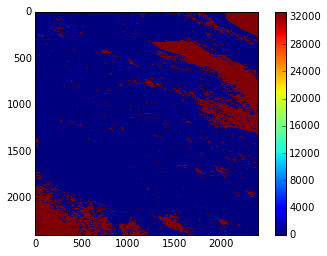

In [57]:
plt.imshow(r_modis(fnames[0])[0])
plt.colorbar()

In [33]:
doys = [i.split('A201')[1].split('.h27')[0][1:] for i in modis_files]

In [42]:
import datetime
dates = zip([datetime.datetime(2015, 1, 1) + datetime.timedelta(int(i) - 1) for i in doys[:4]],doys[:4])\
+zip([datetime.datetime(2016, 1, 1) + datetime.timedelta(int(i) - 1) for i in doys[4:]],doys[4:])

In [43]:
dates

[(datetime.datetime(2015, 12, 3, 0, 0), '337'),
 (datetime.datetime(2015, 12, 11, 0, 0), '345'),
 (datetime.datetime(2015, 12, 19, 0, 0), '353'),
 (datetime.datetime(2015, 12, 27, 0, 0), '361'),
 (datetime.datetime(2016, 1, 1, 0, 0), '001'),
 (datetime.datetime(2016, 1, 9, 0, 0), '009'),
 (datetime.datetime(2016, 1, 17, 0, 0), '017'),
 (datetime.datetime(2016, 1, 25, 0, 0), '025'),
 (datetime.datetime(2016, 2, 2, 0, 0), '033'),
 (datetime.datetime(2016, 2, 10, 0, 0), '041'),
 (datetime.datetime(2016, 2, 18, 0, 0), '049'),
 (datetime.datetime(2016, 2, 26, 0, 0), '057'),
 (datetime.datetime(2016, 3, 5, 0, 0), '065'),
 (datetime.datetime(2016, 3, 13, 0, 0), '073'),
 (datetime.datetime(2016, 3, 21, 0, 0), '081'),
 (datetime.datetime(2016, 3, 29, 0, 0), '089'),
 (datetime.datetime(2016, 4, 6, 0, 0), '097'),
 (datetime.datetime(2016, 4, 14, 0, 0), '105'),
 (datetime.datetime(2016, 4, 22, 0, 0), '113'),
 (datetime.datetime(2016, 4, 30, 0, 0), '121'),
 (datetime.datetime(2016, 5, 8, 0, 0), '12

In [1]:
import datetime

In [ ]:
datetime